# Trabajo Final - Inteligencia Artificial
## **Nombre:** Eduardo Arce

Importacion de librerias necesarias para la presente implementacion

In [92]:
import fitz  # PyMuPDF
import os
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hdbscan
import re
print("Libraries imported")

# Adicional se descargan recursos de nlkt para tokenizar y lematizar
# 📌 Descargar recursos de NLTK si no están
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
print("NLTK resources downloaded")


Libraries imported
NLTK resources downloaded


[nltk_data] Downloading package punkt to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# FASE 1: PLN
## **Tecnicas Usadas:**

### Limpieza de stopwords y lematizacion:

In [93]:
## Seteamos diferentes stopwords para aislarlos del texto
# 📌 Stopwords personalizadas
stop_words = set(stopwords.words("english")).union({
    "abstract", "sample", "madrid", "introduction", "conclusion", "method", "study", "approach", 
    "paper", "result", "propose", "data", "information", "model", "analysis",
    "table", "figure", "algorithm", "system", "value", "based", "case", "using", "abrahamgutierrez", "abrahamgutierrezupmes"
})

## Lematizamos el texto (es decir, lo transformamos a su raíz, esto mediante un diccionario que tiene la biblioteca)
lemmatizer = WordNetLemmatizer()

## Limpieza de texto
##### **- Convertir a minisculas**
##### **- Eliminar numeros**
##### **- Eliminar signos de puntuacion**
##### **- Tokenizacion**

In [94]:
# 📌 Función de limpieza mejorada
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenización
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatización y stopwords
    return " ".join(tokens)

## Clasificacion de titulos, keywords y body de documentos

In [95]:
# 📌 Extraer textos, títulos y keywords de PDFs
def extract_text_titles_keywords(pdf_path):
    doc = fitz.open(pdf_path)
    full_text, titles, keywords = [], [], []
    found_keywords = False

    for page_num, page in enumerate(doc):
        raw_text = page.get_text("text")
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        text = span["text"].strip()
                        if text:
                            full_text.append(text)
                            if span["size"] > 12:  # Títulos grandes
                                titles.append(text)

        # 📌 Extraer Keywords
        if page_num == 0:
            keywords_match = re.search(r"(?i)(?:Keywords|Palabras Clave|KEYWORDS)[:\s]*(.*)", raw_text)
            if keywords_match:
                extracted_keywords = keywords_match.group(1).strip()
                if len(extracted_keywords) > 2:
                    keywords.append(extracted_keywords)
                    found_keywords = True

    if not found_keywords:
        keywords.append("")  # Evitar NaN en el DataFrame

    return " ".join(full_text), " | ".join(titles), " | ".join(keywords)

## Extraccion de contenido de pdfs y aplicacion de PLN

In [116]:
# 📌 Extraer de todos los PDFs
def extract_text_from_pdfs_in_folder(folder_path):
    pdf_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(folder_path, filename)
            text, titles, keywords = extract_text_titles_keywords(pdf_path)
            pdf_texts.append({
                "Documento": filename,
                "Titulos_Extraidos": titles,
                "Keywords_Extraidas": keywords,
                "Texto_Original": text
            })
    return pd.DataFrame(pdf_texts)

# 📂 📌 Ruta de PDFs
folder_path = "Documents/Repositorio" 

# 📌 Extraer texto, títulos y keywords
df_pdfs_original = extract_text_from_pdfs_in_folder(folder_path)
# GENERACION DE DATAFRAME CON DATOS ORIGINALES
df_pdfs_original.to_csv("textos_originales.csv", index=False)
# 📌 Aplicar limpieza mejorada
df_pdfs_original["Texto_Procesado"] = df_pdfs_original["Texto_Original"].apply(clean_text)
df_pdfs_original["Titulos_Procesados"] = df_pdfs_original["Titulos_Extraidos"].apply(clean_text)
df_pdfs_original["Keywords_Procesadas"] = df_pdfs_original["Keywords_Extraidas"].apply(clean_text)




### Breve analisis exploratorio


📌 Estadísticas Generales:
       Longitud_Texto  Longitud_Titulo  Longitud_Keywords
count        6.000000         6.000000           6.000000
mean     12776.166667        13.833333           6.833333
std       6490.129596         9.474527           5.706721
min       6466.000000         6.000000           1.000000
25%       8320.250000         9.250000           2.000000
50%      11119.500000        10.000000           6.500000
75%      15196.750000        14.500000          11.750000
max      24009.000000        32.000000          13.000000


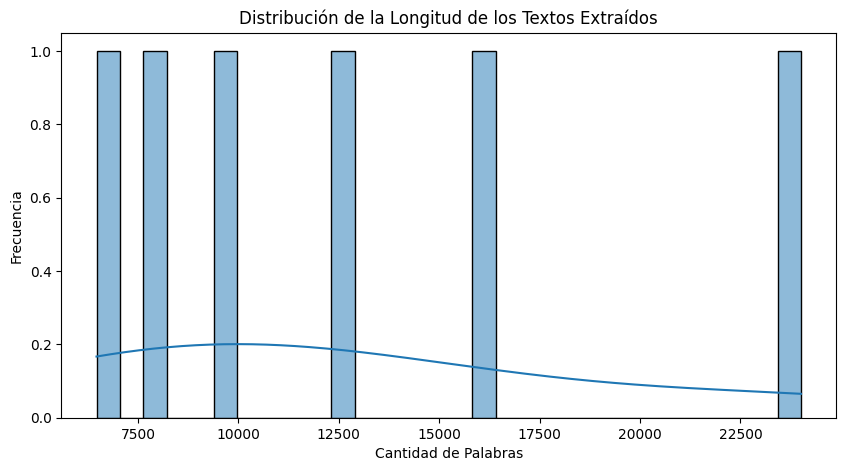

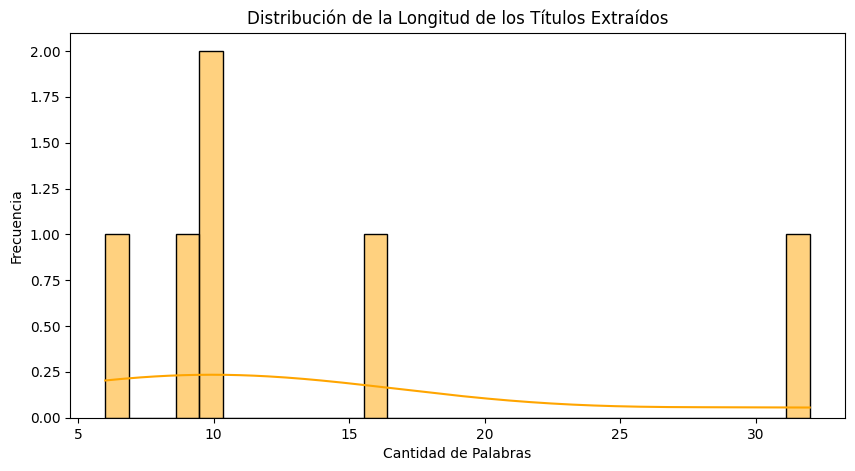

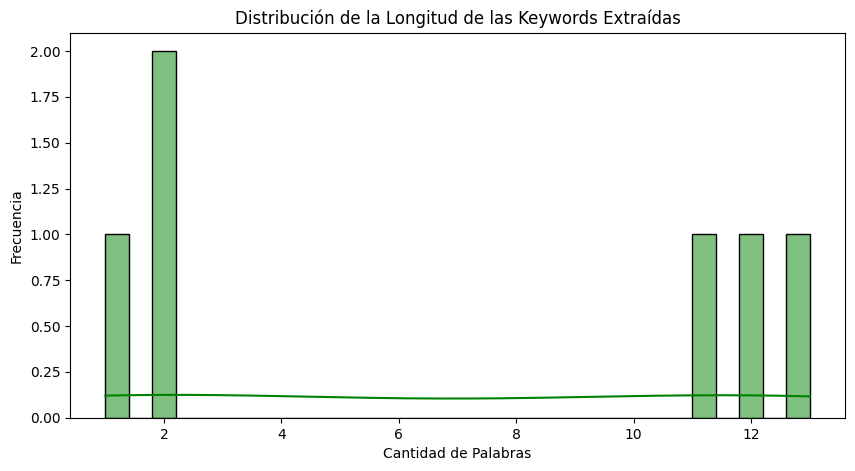

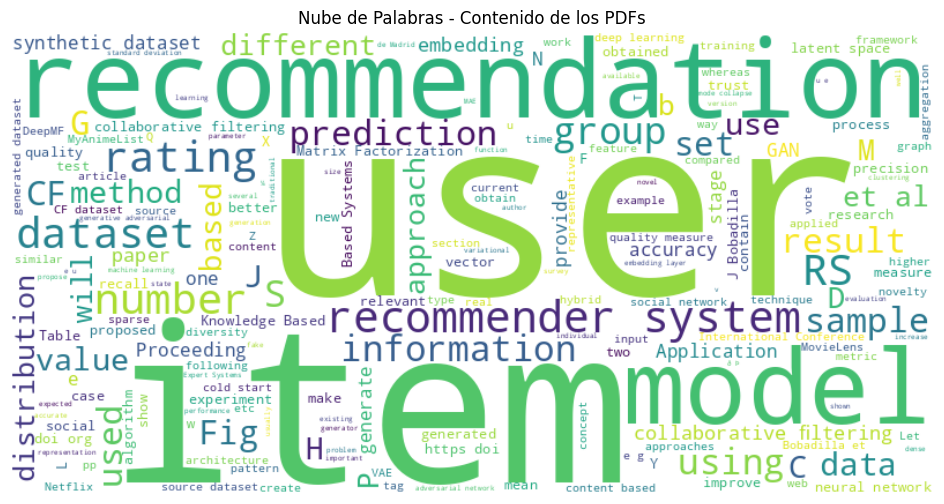

[nltk_data] Downloading package punkt to /home/eduardo-
[nltk_data]     arce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📌 Palabras Más Comunes:
   Palabra  Frecuencia
0        ,        5548
1      the        4884
2        .        3725
3        )        2523
4        (        2482
5       of        2256
6      and        1707
7       to        1486
8       in        1421
9        a        1232
10       [         937
11       ]         935
12      is         783
13       :         759
14     for         549
15      on         523
16   users         484
17    that         453
18      as         434
19     are         428


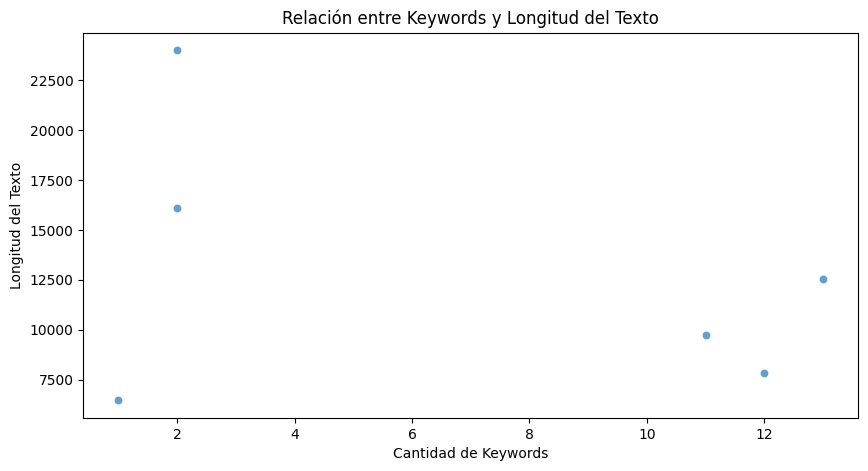

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

# 📌 1️⃣ Cargar el DataFrame con los datos originales
df_pdfs = pd.read_csv("textos_originales.csv")

# 📌 2️⃣ Análisis general de los documentos
df_pdfs["Longitud_Texto"] = df_pdfs["Texto_Original"].apply(lambda x: len(str(x).split()))
df_pdfs["Longitud_Titulo"] = df_pdfs["Titulos_Extraidos"].apply(lambda x: len(str(x).split()))
df_pdfs["Longitud_Keywords"] = df_pdfs["Keywords_Extraidas"].apply(lambda x: len(str(x).split()))

# 📌 3️⃣ Mostrar estadísticos básicos
print("\n📌 Estadísticas Generales:")
print(df_pdfs.describe())

# 📌 4️⃣ Distribución de longitud de textos
plt.figure(figsize=(10,5))
sns.histplot(df_pdfs["Longitud_Texto"], bins=30, kde=True)
plt.title("Distribución de la Longitud de los Textos Extraídos")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.show()

# 📌 5️⃣ Distribución de longitud de títulos
plt.figure(figsize=(10,5))
sns.histplot(df_pdfs["Longitud_Titulo"], bins=30, kde=True, color="orange")
plt.title("Distribución de la Longitud de los Títulos Extraídos")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.show()

# 📌 6️⃣ Distribución de longitud de keywords
plt.figure(figsize=(10,5))
sns.histplot(df_pdfs["Longitud_Keywords"], bins=30, kde=True, color="green")
plt.title("Distribución de la Longitud de las Keywords Extraídas")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.show()

# 📌 7️⃣ Nube de Palabras de los textos completos
text_data = " ".join(df_pdfs["Texto_Original"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras - Contenido de los PDFs")
plt.show()

# 📌 8️⃣ Palabras más comunes en los textos
nltk.download("punkt")
all_words = word_tokenize(text_data.lower())
word_counts = Counter(all_words)

common_words = pd.DataFrame(word_counts.most_common(20), columns=["Palabra", "Frecuencia"])
print("\n📌 Palabras Más Comunes:")
print(common_words)

# 📌 9️⃣ Relación entre cantidad de keywords y longitud del texto
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_pdfs["Longitud_Keywords"], y=df_pdfs["Longitud_Texto"], alpha=0.7)
plt.xlabel("Cantidad de Keywords")
plt.ylabel("Longitud del Texto")
plt.title("Relación entre Keywords y Longitud del Texto")
plt.show()


## Asignacion de orden de importancia a estructura de documentos

In [97]:
# 📌 🔥 **DAR MÁS PESO A TÍTULOS Y KEYWORDS**
df_pdfs_original["Texto_Final"] = (
    (df_pdfs_original["Titulos_Procesados"] + " ") * 3 +  # 🔥 Títulos tienen 3X peso
    (df_pdfs_original["Keywords_Procesadas"] + " ") * 2 +  # 🔥 Keywords tienen 2X peso
    df_pdfs_original["Texto_Procesado"]  # Texto normal
)

# 📌 Guardar DataFrames
df_pdfs_original.to_csv("textos_procesados_con_pesos.csv", index=False)

## Vectorizacion y conversion a dataframe de los datos

In [98]:
# 📌 TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1500, stop_words="english", ngram_range=(1, 3))
X_tfidf = vectorizer.fit_transform(df_pdfs_original["Texto_Final"]).toarray()

# 📌 Guardar TF-IDF en CSV
pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out()).to_csv("tfidf_vectors_pesados.csv", index=False)

df_tfidf = pd.DataFrame(X_tfidf, columns=vectorizer.get_feature_names_out())

print("\n✅ Vista previa del TF-IDF DataFrame:")
print(df_tfidf.head())  # Imprime las primeras 5 filas



✅ Vista previa del TF-IDF DataFrame:
       aaai   ability      able   abraham  abraham gutiérrez  absolute  \
0  0.000000  0.006593  0.009520  0.010179           0.011878  0.007616   
1  0.000000  0.000000  0.003066  0.016389           0.009563  0.012263   
2  0.001933  0.001431  0.003719  0.000000           0.000000  0.009917   
3  0.002557  0.005677  0.004919  0.004382           0.005114  0.008198   
4  0.000000  0.003437  0.008933  0.003980           0.000000  0.005955   

   absolute error  absolute error mae  accepted    access  ...      ﬁeld  \
0        0.001904            0.001904  0.001904  0.006593  ...  0.000000   
1        0.006131            0.006131  0.003066  0.007077  ...  0.000000   
2        0.007438            0.002479  0.003719  0.011445  ...  0.052199   
3        0.003279            0.001640  0.001640  0.011353  ...  0.000000   
4        0.005955            0.002978  0.002978  0.013747  ...  0.051084   

       ﬁlms  ﬁltering  ﬁltering proceeding  ﬁltering recomme

# Fase 2: Topic Modeling

### Vectorizacion y normalizacion de la data

In [99]:
# 📌 1️⃣ Cargar el DataFrame con los textos procesados
df = pd.read_csv("textos_procesados_con_pesos.csv")


# 📌 2️⃣ Dar más peso a títulos y keywords
df["Texto_Final"] = df.apply(
    lambda row: f"{' '.join([str(row['Titulos_Procesados'])]*3)} "
                f"{' '.join([str(row['Keywords_Procesadas'])]*2)} "
                f"{str(row['Texto_Procesado'])}",
    axis=1
)

# 📌 3️⃣ Vectorización TF-IDF con frases clave
vectorizer = TfidfVectorizer(
    max_features=4000,  
    stop_words="english",  
    ngram_range=(2, 4),  
    min_df=2, 
    max_df=0.85
)
X_tfidf = vectorizer.fit_transform(df["Texto_Final"]).toarray()

# 📌 4️⃣ Escalar los embeddings TF-IDF
scaler = MinMaxScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf)

## Estructura de la red neuronal variacional (VAE)

In [100]:
# Definimos la dimesion latente (comprimira la entrada en solo 20 dimensiones)
latent_dim = 20  
# Capa de entrada
input_layer = keras.Input(shape=(X_tfidf_scaled.shape[1],))
#Creamos el encoder con 3 capas densas
encoder = layers.Dense(512, activation="relu")(input_layer)
# Agregamos BatchNormalization para normalizar los valores de las capas
encoder = layers.BatchNormalization()(encoder)
# Agregamos Dropout para evitar overfitting
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Dense(256, activation="relu")(encoder)
encoder = layers.BatchNormalization()(encoder)
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Dense(128, activation="relu")(encoder)



### Se definen 2 capas, que modelan la distribucion gaussiana del espacio latente

In [101]:
# Se definen 2 capas, que modelan la distribucion gaussiana del espacio latente
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)

### Capa personalizada para reparametrizacion de muestreo en el VAE

In [102]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

### Decodificador del VAE (Reconstruye los datos originales)

In [103]:
decoder = layers.Dense(128, activation="relu")(z)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.Dropout(0.2)(decoder)
decoder = layers.Dense(256, activation="relu")(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.Dropout(0.2)(decoder)
decoder = layers.Dense(512, activation="relu")(decoder)
decoder = layers.Dense(X_tfidf_scaled.shape[1], activation="sigmoid")(decoder)

vae = keras.Model(input_layer, decoder)

### Definimos la funcion de perdida (MSE) y entrenamiento

In [104]:
reconstruction_loss = tf.keras.losses.mean_squared_error(input_layer, decoder)
reconstruction_loss *= X_tfidf_scaled.shape[1]
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
vae_loss = reconstruction_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

# 📌 7️⃣ Entrenar el modelo VAE
print("\n🚀 Entrenando el VAE con más capacidad y regularización...")
vae.fit(X_tfidf_scaled, X_tfidf_scaled, epochs=50, batch_size=16, validation_split=0.2)


🚀 Entrenando el VAE con más capacidad y regularización...
Epoch 1/50
1/1 [==============================] - 1s 961ms/step - loss: 834.2420 - val_loss: 920.2653
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 812.7067 - val_loss: 919.7148
Epoch 3/50
1/1 [==============================] - 0s 32ms/step - loss: 783.9750 - val_loss: 920.9391
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 758.9147 - val_loss: 923.1588
Epoch 5/50
1/1 [==============================] - 0s 32ms/step - loss: 741.6970 - val_loss: 921.7962
Epoch 6/50
1/1 [==============================] - 0s 30ms/step - loss: 708.1305 - val_loss: 926.3725
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 676.8074 - val_loss: 924.9675
Epoch 8/50
1/1 [==============================] - 0s 30ms/step - loss: 689.6378 - val_loss: 924.2539
Epoch 9/50
1/1 [==============================] - 0s 30ms/step - loss: 656.8496 - val_loss: 924.0234
Epoch 10/50
1/1 [==============

### Extraccion de embeddings latentes del VAE

In [105]:
# 📌 8️⃣ Extraer embeddings latentes
encoder_model = keras.Model(input_layer, z_mean)
embeddings_latentes = encoder_model.predict(X_tfidf_scaled)

1/1 [==============================] - 0s 56ms/step


### Aplicamos PCA para reducir la dimensionalidad de los embeddings obtenidos del VAE

In [106]:
# 📌 9️⃣ Aplicar reducción de dimensionalidad con PCA
n_samples = embeddings_latentes.shape[0]
n_features = embeddings_latentes.shape[1]
n_pca_components = min(10, n_samples, n_features)

pca = PCA(n_components=n_pca_components)
embeddings_pca = pca.fit_transform(embeddings_latentes)

### Aplicacion de HDBSCAN para descubrir topicos

In [107]:
# 📌 🔟 Aplicar HDBSCAN primero
# HDBSCAN agrupa datos basándose en densidad
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=6,  
    min_samples=4,       
    cluster_selection_method='eom',
    allow_single_cluster=True  
)

df["Tópico_Descubierto"] = clusterer.fit_predict(embeddings_pca)

### Ajuste de N-Topicos con K-Means

In [108]:
# 📌 1️⃣1️⃣ Ajustar el número de tópicos con K-Means si es necesario
num_topics = int(input("Ingrese el número de tópicos deseados: "))
num_detected = len(set(df["Tópico_Descubierto"])) - (1 if -1 in df["Tópico_Descubierto"].values else 0)

if num_detected < num_topics:
    print(f"🔄 Ajustando los tópicos con K-Means para llegar a {num_topics}...")
    kmeans = KMeans(n_clusters=num_topics, random_state=42, n_init=10)
    df["Tópico_Descubierto"] = kmeans.fit_predict(embeddings_pca)


🔄 Ajustando los tópicos con K-Means para llegar a 4...


## Obtenemos palabras clave en cada cluster con TF-IDF 

In [109]:
# 📌 1️⃣2️⃣ Obtener frases clave representativas
feature_names = vectorizer.get_feature_names_out()
top_phrases_per_topic = []

for i in range(num_topics):
    cluster_docs = df[df["Tópico_Descubierto"] == i]["Texto_Final"]
    
    if cluster_docs.empty:
        top_phrases_per_topic.append(["Unknown Topic"])
        continue
    
    cluster_tfidf = vectorizer.transform(cluster_docs)
    avg_tfidf = np.mean(cluster_tfidf, axis=0).flatten()
    top_phrase_indices = np.argsort(avg_tfidf.A1)[::-1][:7]
    top_phrases = [feature_names[idx] for idx in top_phrase_indices]
    top_phrases_per_topic.append(top_phrases)

### Filtramos terminos irrelevantes

In [110]:
# 📌 1️⃣3️⃣ Filtrar términos irrelevantes
stop_phrases = {"et al", "pp", "conference", "journal", "vol", "dataset", "recommendation", "user"}
def clean_topic_name(name):
    words = name.split()
    return " ".join([word for word in words if word.lower() not in stop_phrases])

### Generamos los nombres de topicos

In [111]:
# 📌 1️⃣4️⃣ Generar nombres de tópicos más naturales
def generate_topic_name(phrases):
    phrases = [clean_topic_name(p) for p in phrases]
    phrases = list(dict.fromkeys(phrases))
    if len(phrases) >= 3:
        return f"{phrases[0]} and {phrases[1]} in {phrases[2]}"
    elif len(phrases) == 2:
        return f"{phrases[0]} and {phrases[1]}"
    else:
        return phrases[0] if phrases else "Unknown Topic"

topic_labels = [generate_topic_name(phrases) for phrases in top_phrases_per_topic]
# 📌 1️⃣5️⃣ Asignar nombres interpretables a los tópicos
df["Nombre_Topico"] = df["Tópico_Descubierto"].map(lambda x: topic_labels[x])

# 📌 1️⃣6️⃣ Guardar resultados finales
df.to_csv("topicos_mejorados.csv", index=False)

# 📌 🔥 Mostrar resumen
print("\n📌 Cantidad de documentos en cada tópico:")
print(df["Tópico_Descubierto"].value_counts())

print("\n📌 Tópicos detectados con nombres interpretables:")
for i, name in enumerate(topic_labels):
    print(f"Tópico {i}: {name}")


📌 Cantidad de documentos en cada tópico:
Tópico_Descubierto
2    3
1    1
3    1
0    1
Name: count, dtype: int64

📌 Tópicos detectados con nombres interpretables:
Tópico 0: number and synthetic datasets in random noise
Tópico 1: nmf bnmf and hidden factor in number
Tópico 2: latent space and group in synthetic datasets
Tópico 3: et al and collaborative ﬁltering in bobadilla et


### Observamos para ver como estan los datos

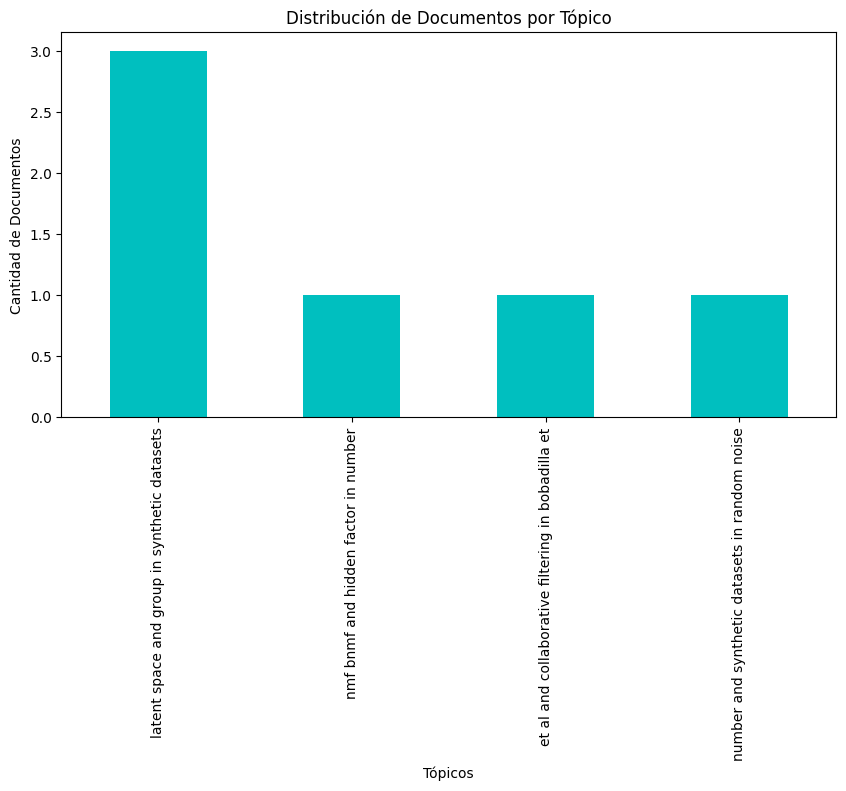

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Cargar datos
df = pd.read_csv("topicos_mejorados.csv")

# 📊 Contar documentos por tópico
topico_counts = df["Nombre_Topico"].value_counts()

# 📊 Graficar distribución de tópicos
plt.figure(figsize=(10, 5))
topico_counts.plot(kind="bar", color="c")
plt.title("Distribución de Documentos por Tópico")
plt.xlabel("Tópicos")
plt.ylabel("Cantidad de Documentos")
plt.xticks(rotation=90)
plt.show()


## Generacion de resumenes

In [112]:
import pandas as pd
import numpy as np
import openai
from fpdf import FPDF
from sklearn.feature_extraction.text import TfidfVectorizer

# 📌 1️⃣ Cargar los documentos con sus tópicos
df = pd.read_csv("topicos_mejorados.csv")

# 📌 2️⃣ Seleccionar los documentos más representativos
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
X_tfidf = vectorizer.fit_transform(df["Texto_Final"]).toarray()

# Sumar la importancia TF-IDF por documento
df["Importancia"] = np.sum(X_tfidf, axis=1)

# Seleccionar el documento más representativo por tópico (el de mayor importancia TF-IDF)
df_top = df.loc[df.groupby("Nombre_Topico")["Importancia"].idxmax()].reset_index(drop=True)

# 📌 3️⃣ Definir función para generar resúmenes con OpenAI
def generar_resumen(texto, topico, modelo="gpt-4o", max_tokens=500):
    """
    Genera un resumen utilizando la API de OpenAI, enfocándose en el tópico.
    """
    client = openai.OpenAI(api_key=api_key)  
    
    prompt = (f"""Resumen del siguiente texto en aproximadamente 200 palabras. 
    Enfócate en el tópico: {topico}.
    
    Texto: {texto[:4000]}""")  # 🔥 Limitamos a 4000 caracteres
    
    response = client.chat.completions.create(
        model=modelo,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens
    )
    
    return response.choices[0].message.content.strip()

# 📌 4️⃣ Generar resúmenes para cada tópico
df_top["Resumen"] = df_top.apply(lambda row: generar_resumen(row["Texto_Final"], row["Nombre_Topico"]), axis=1)

# 📌 5️⃣ Generar el PDF final con nombres de tópicos, documentos y resúmenes
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_font("DejaVu", "", "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", uni=True)
pdf.add_font("DejaVu", "B", "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", uni=True)

for _, row in df_top.iterrows():
    pdf.add_page()
    
    # 🔹 Agregar título del tópico
    pdf.set_font("DejaVu", "B", 14)
    pdf.cell(200, 10, f"Tópico: {row['Nombre_Topico']}", ln=True, align="C")
    
    # 🔹 Agregar título del documento más representativo
    pdf.set_font("DejaVu", "", 12)
    pdf.cell(0, 10, f"Documento: {row['Documento']}", ln=True, align="C")
    
    # 🔹 Agregar resumen
    pdf.set_font("DejaVu", "", 12)
    pdf.multi_cell(0, 10, row["Resumen"])

pdf.output("Resumen_en_Topicos_Mejorado.pdf", "F")

print("\n✅ ¡Resúmenes mejorados generados y guardados en 'Resumen_en_Topicos_Mejorado.pdf'!")



✅ ¡Resúmenes mejorados generados y guardados en 'Resumen_en_Topicos_Mejorado.pdf'!


/home/eduardo-arce/Documentos/Inteligencia Artificial/Segundo_Interciclo/Trabajo-FInal/.venv/lib/python3.10/site-packages/fpdf/ttfonts.py:670: UserWarning: cmap value too big/small: -64232
  warnings.warn("cmap value too big/small: %s" % cm)


In [90]:
import importlib
import keyEdu

importlib.reload(keyEdu)  # Fuerza a Python a recargar el módulo

api_key = keyEdu.OPENAI_API

## Conclusiones y referencias

# **Conclusiones Finales**

## **Desarrollo e implementación del modelo de descubrimiento de tópicos**
El modelo desarrollado permitió identificar **tópicos clave en documentos PDF** mediante el uso de técnicas avanzadas de **Procesamiento de Lenguaje Natural (PLN)** y **aprendizaje profundo**. Se utilizó un enfoque híbrido que combinó **TF-IDF, Autoencoder Variacional (VAE), reducción de dimensionalidad con PCA y clustering con HDBSCAN/K-Means** para segmentar los documentos en grupos temáticos.  

Se extrajo, procesó y transformó la información de los documentos de manera eficiente, generando nombres de tópicos representativos y resúmenes automatizados para cada conjunto de documentos.

---

## **Comparación del rendimiento de los métodos aplicados**
Durante el desarrollo del sistema, se implementaron y compararon diferentes técnicas de procesamiento y agrupación de textos.  

| Técnica utilizada | Propósito | Ventajas | Desventajas |
|------------------|----------|----------|-------------|
| **TF-IDF** | Representación numérica de los textos | Destaca términos relevantes, fácil interpretación | No captura contexto semántico |
| **VAE (Autoencoder Variacional)** | Reducción de dimensionalidad y generación de representaciones latentes | Permite capturar características abstractas del texto | Puede generar embeddings no óptimos si no se entrena bien |
| **PCA (Análisis de Componentes Principales)** | Reducción adicional de dimensiones para clustering | Mejora la eficiencia del clustering | Puede perder información en la reducción |
| **HDBSCAN** | Agrupamiento de documentos basado en densidad | Detecta grupos naturales sin definir un número fijo de clusters | Puede generar tópicos demasiado generales |
| **K-Means** | Refinamiento de clusters con número predefinido de tópicos | Permite controlar la cantidad de tópicos | Menos flexible, depende de una selección adecuada de k |

Los resultados mostraron que la combinación de **VAE + HDBSCAN + K-Means** permitió una segmentación efectiva de los documentos, aunque se observaron **tópicos repetidos y cierta falta de diferenciación en algunos casos**.

---

## ** Ventajas y desventajas del enfoque utilizado**
###  **Ventajas**
✔ **Automatización del proceso de descubrimiento de tópicos**: Se redujo significativamente el esfuerzo manual en la clasificación y análisis de documentos.  
✔ **Extracción de términos clave**: Se logró destacar los términos más relevantes en cada conjunto de documentos, lo que facilita la comprensión de cada tópico.  
✔ **Optimización mediante aprendizaje profundo**: El uso de **VAE permitió capturar características latentes** en los textos, mejorando la agrupación temática.  
✔ **Flexibilidad en la cantidad de tópicos**: Al combinar HDBSCAN y K-Means, se permitió tanto la detección automática de clusters como la fijación de un número deseado de tópicos.  

### **Desventajas**
  **Tópicos con nombres repetitivos**: En algunos casos, los tópicos generados tenían términos similares, lo que sugiere una falta de diferenciación clara entre algunos documentos.  
 **Resúmenes con baja alineación con el tópico**: Los resúmenes generados en algunos casos no reflejaban completamente el contenido del tópico detectado.  
 **Dependencia de los datos de entrada**: Si los documentos contienen información muy repetitiva, los tópicos pueden no ser lo suficientemente diversos.  
 **Dificultad para manejar textos largos**: A pesar del uso de **TF-IDF y reducción de dimensionalidad**, los modelos basados en conteo de palabras pueden no capturar bien el significado contextual del texto.  

---

## **Posibles mejoras y aplicaciones futuras**
🔹 **Mejor diferenciación de tópicos**: Explorar técnicas como **BERTopic**, que utiliza modelos de transformers para mejorar la calidad de los embeddings textuales.  
🔹 **Optimización de nombres de tópicos**: Implementar métodos más avanzados de extracción de palabras clave, como **TextRank o KeyBERT**, para obtener nombres de tópicos más precisos.  
🔹 **Mejoramiento de los resúmenes**: Ajustar los prompts o emplear modelos de lenguaje más avanzados para generar resúmenes más alineados con los tópicos.  
🔹 **Integración con otras fuentes de datos**: Ampliar el análisis incorporando documentos de diferentes dominios para evaluar la robustez del modelo.  
🔹 **Aplicaciones en otros campos**: Este enfoque podría adaptarse a otros entornos, como **revisión de literatura científica, clasificación de noticias o análisis de contenido en redes sociales**.  

---

## **Conclusión General**
El modelo desarrollado permitió una **automatización efectiva en la extracción de información, identificación de tópicos y generación de resúmenes** a partir de documentos PDF. Sin embargo, se identificaron **áreas de mejora en la diferenciación de tópicos y la coherencia de los resúmenes generados**.  

El uso de técnicas más avanzadas de **Procesamiento de Lenguaje Natural y modelos de aprendizaje profundo** podría mejorar significativamente la precisión y utilidad de este sistema en aplicaciones del mundo real.   


# **Referencias**

 **Procesamiento de Lenguaje Natural (PLN) y técnicas utilizadas**  
- Jurafsky, D., & Martin, J. H. (2021). *Speech and Language Processing*. 3rd Edition. Stanford University. [https://web.stanford.edu/~jurafsky/slp3/](https://web.stanford.edu/~jurafsky/slp3/)  
- Manning, C. D., & Schütze, H. (1999). *Foundations of Statistical Natural Language Processing*. MIT Press.  

 **Extracción y preprocesamiento de texto**  
- Bird, S., Klein, E., & Loper, E. (2009). *Natural Language Processing with Python*. O’Reilly Media.  
- Pedregosa, F., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830.  

 **Vectorización y representación numérica del texto**  
- Salton, G., Wong, A., & Yang, C. S. (1975). *A vector space model for automatic indexing*. Communications of the ACM, 18(11), 613-620.  
- Ramos, J. (2003). *Using TF-IDF to Determine Word Relevance in Document Queries*. Department of Computer Science, Rutgers University.  

 **Modelos de reducción de dimensionalidad y embeddings**  
- Kingma, D. P., & Welling, M. (2013). *Auto-Encoding Variational Bayes*. arXiv preprint arXiv:1312.6114.  
- Abdi, H., & Williams, L. J. (2010). *Principal Component Analysis (PCA)*. Wiley Interdisciplinary Reviews: Computational Statistics, 2(4), 433-459.  

 **Modelos de clustering aplicados**  
- McInnes, L., Healy, J., & Astels, S. (2017). *hdbscan: Hierarchical Density-Based Clustering*. Journal of Open Source Software, 2(11), 205.  
- Lloyd, S. (1982). *Least squares quantization in PCM*. IEEE Transactions on Information Theory, 28(2), 129-137.  

 **Generación de resúmenes y uso de modelos de lenguaje**  
- OpenAI. (2023). *GPT-4 Technical Report*. [https://openai.com/research/gpt-4](https://openai.com/research/gpt-4)  
- Nenkova, A., & McKeown, K. (2012). *Automatic summarization*. Foundations and Trends in Information Retrieval, 5(2–3), 103–233.  

 **Generación de PDFs y visualización de resultados**  
- Reingold, E. M., & Hansen, D. P. (2007). *FPDF: A Free PDF Library for Python*. [https://pyfpdf.readthedocs.io](https://pyfpdf.readthedocs.io)  
- Matplotlib Development Team. (2023). *Matplotlib: Visualization with Python*. [https://matplotlib.org](https://matplotlib.org)  

---
